<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/9_QMAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 1.4 MB/s eta 0:00:00


<ipython-input-12-33909c2b95a1>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-12-33909c2b95a1>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-12-33909c2b95a1>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

Accuracy: 0.8041668060060864
Precision: 0.07797873307279833
Recall: 0.35381443298969073


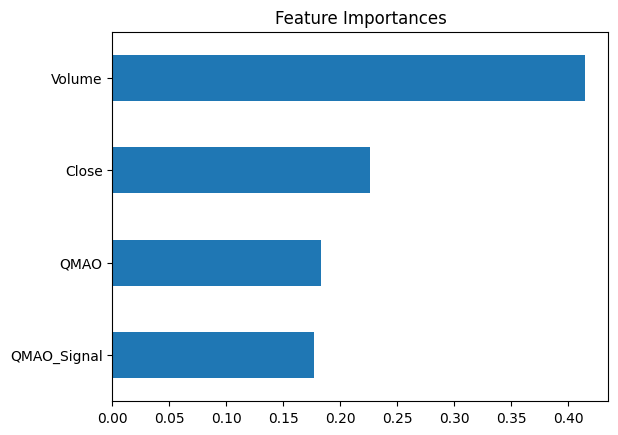

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-31  032820   2420  82890400
2024-05-21  027580   2040  58493574
2024-05-17  041020   9440  32397000
2024-05-24  403490   2580  27450366
2024-05-16  043260   2245  26924723
2024-05-23  027830   2605  25051914
2024-05-30  131400   3050  23533711
2024-05-20  291230   2940  16155333
2024-05-29  060310   2935  15743678
2024-02-14  037330   2380  13966880
종목 코드: 032820
현재 단계: Eating
실시간 현재가: 2420
최근 종가: 2420
현재 추세: 상승 추세
52주 최고가: 2650.0
52주 최저가: 1248.0
52주 중간가격: 1949.0
매수 범위: (-8.30617044474872, 18.582841401023217)
1차 매수 목표: 15.31679816375602
2차 매수 목표: 0.39312681840544744
익절가: 2915.0000000000005
손절가: 1185.6
종목 코드: 027580
현재 단계: Sleeping
실시간 현재가: 1734
최근 종가: 1734
현재 추세: 하락 추세
52주 최고가: 2530.0
52주 최저가: 1513.0
52주 중간가격: 2021.5
매수 범위: (-9.20118605062843, 13.980793271962725)
1차 매수 목표: 2.072787321457894
2차 매수 목표: 1.1280123227654058
익절가: 2783.0
손절가: 1437.35
종목 코드: 041020
현재 단계: Sleeping
실시간 현재가: 8070
최근 종가: 8

In [ ]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# QMAO 계산 함수
def calculate_qmao(data):
    ma7 = data['Close'].rolling(window=7).mean()
    ma14 = data['Close'].rolling(window=14).mean()
    ma28 = data['Close'].rolling(window=28).mean()
    ma56 = data['Close'].rolling(window=56).mean()

    A = (ma7 - ma14) * (7 + 14) / 315 + (ma7 - ma28) * (7 + 28) / 315 + (ma7 - ma56) * (7 + 56) / 315
    B = (ma14 - ma28) * (14 + 28) / 315 + (ma14 - ma56) * (14 + 56) / 315
    C = (ma28 - ma56) * (28 + 56) / 315

    qmao = (A + B + C) / data['Close'] * 100
    signal_line = qmao.rolling(window=7).mean()

    return qmao, signal_line

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 1000 and data['Close'].iloc[-1] <= 10000:
            data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'QMAO', 'QMAO_Signal']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])

# 상위 10개 종목의 상세 정보 출력
for ticker in top_10_gainers['Code']:
    stock_data = fdr.DataReader(ticker, start_date, end_date)
    stock_data['QMAO'], stock_data['QMAO_Signal'] = calculate_qmao(stock_data)

    # 최신 데이터 포인트의 단계 표시
    short_ma = stock_data['QMAO']
    long_ma = stock_data['QMAO_Signal']
    current_phase = 'Sleeping'
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        current_phase = 'Awakening' if short_ma.iloc[-2] <= long_ma.iloc[-2] else 'Eating'

    # 실시간 가격 가져오기 (예시로 최근 종가 사용)
    current_price = stock_data['Close'].iloc[-1]

    # 추가 메트릭 계산
    latest_close = stock_data['Close'].iloc[-1]
    current_trend = "상승 추세" if stock_data['QMAO'].iloc[-1] > stock_data['QMAO_Signal'].iloc[-1] else "하락 추세"
    fifty_two_week_high = stock_data['Close'].rolling(window=252).max().iloc[-1]
    fifty_two_week_low = stock_data['Close'].rolling(window=252).min().iloc[-1]
    fifty_two_week_mid = (fifty_two_week_high + fifty_two_week_low) / 2

    # 매수 범위와 목표 정의
    buy_range = (stock_data['QMAO'].min(), stock_data['QMAO'].max())
    first_buy_target = stock_data['QMAO_Signal'].iloc[-1]
    second_buy_target = stock_data['QMAO'].mean()
    profit_target = fifty_two_week_high * 1.1
    stop_loss = fifty_two_week_low * 0.95

    # 결과 표시
    print(f"종목 코드: {ticker}")
    print("현재 단계:", current_phase)
    print("실시간 현재가:", current_price)
    print("최근 종가:", latest_close)
    print("현재 추세:", current_trend)
    print("52주 최고가:", fifty_two_week_high)
    print("52주 최저가:", fifty_two_week_low)
    print("52주 중간가격:", fifty_two_week_mid)
    print("매수 범위:", buy_range)
    print("1차 매수 목표:", first_buy_target)
    print("2차 매수 목표:", second_buy_target)
    print("익절가:", profit_target)
    print("손절가:", stop_loss)
    print("="*50)


<ipython-input-13-f9a50ee782e8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-13-f9a50ee782e8>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-13-f9a50ee782e8>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

Accuracy: 0.8077184466019417
Precision: 0.07386208776233306
Recall: 0.3249400479616307


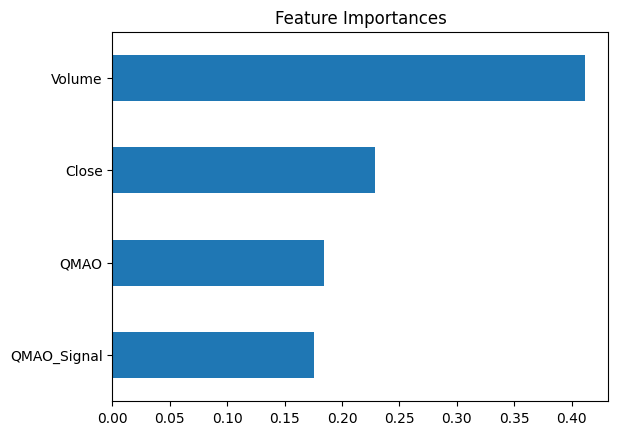

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-30  051980   8910  12272620
2024-03-13  007820   6300  11413628
2024-05-31  298830   6540   8315392
2024-05-24  297890   6680   6503864
2024-02-29  261200  10260   6202193
2024-05-14  086040   5740   5696961
2023-10-25  054050   8710   5230149
2024-05-29  323280   5680   5169241
2024-05-23  115450   7610   4906247
2024-05-21  215100   5400   4889124
종목 코드: 051980
현재 단계: Eating
실시간 현재가: 9520
최근 종가: 9520
현재 추세: 상승 추세
52주 최고가: 10650.0
52주 최저가: 1358.0
52주 중간가격: 6004.0
매수 범위: (-54.526585548308674, 35.42777206805984)
1차 매수 목표: 10.510775631809974
2차 매수 목표: 0.5738451416292877
익절가: 11715.000000000002
손절가: 1290.1
종목 코드: 007820
현재 단계: Sleeping
실시간 현재가: 5150
최근 종가: 5150
현재 추세: 하락 추세
52주 최고가: 7380.0
52주 최저가: 4955.0
52주 중간가격: 6167.5
매수 범위: (-8.930264235323762, 7.041352271046011)
1차 매수 목표: -1.5532314415547792
2차 매수 목표: -1.002691272150018
익절가: 8118.000000000001
손절가: 4707.25
종목 코드: 298830
현재 단계: Eating
실시간 현재가: 

In [ ]:
# 필요한 패키지 설치
!pip install finance-datareader
!pip install imbalanced-learn

import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# QMAO 계산 함수
def calculate_qmao(data):
    ma7 = data['Close'].rolling(window=7).mean()
    ma14 = data['Close'].rolling(window=14).mean()
    ma28 = data['Close'].rolling(window=28).mean()
    ma56 = data['Close'].rolling(window=56).mean()

    A = (ma7 - ma14) * (7 + 14) / 315 + (ma7 - ma28) * (7 + 28) / 315 + (ma7 - ma56) * (7 + 56) / 315
    B = (ma14 - ma28) * (14 + 28) / 315 + (ma14 - ma56) * (14 + 56) / 315
    C = (ma28 - ma56) * (28 + 56) / 315

    qmao = (A + B + C) / data['Close'] * 100
    signal_line = qmao.rolling(window=7).mean()

    return qmao, signal_line

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5000 and data['Close'].iloc[-1] <= 10000:
            data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'QMAO', 'QMAO_Signal']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])

# 상위 10개 종목의 상세 정보 출력
for ticker in top_10_gainers['Code']:
    stock_data = fdr.DataReader(ticker, start_date, end_date)
    stock_data['QMAO'], stock_data['QMAO_Signal'] = calculate_qmao(stock_data)

    # 최신 데이터 포인트의 단계 표시
    short_ma = stock_data['QMAO']
    long_ma = stock_data['QMAO_Signal']
    current_phase = 'Sleeping'
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        current_phase = 'Awakening' if short_ma.iloc[-2] <= long_ma.iloc[-2] else 'Eating'

    # 실시간 가격 가져오기 (예시로 최근 종가 사용)
    current_price = stock_data['Close'].iloc[-1]

    # 추가 메트릭 계산
    latest_close = stock_data['Close'].iloc[-1]
    current_trend = "상승 추세" if stock_data['QMAO'].iloc[-1] > stock_data['QMAO_Signal'].iloc[-1] else "하락 추세"
    fifty_two_week_high = stock_data['Close'].rolling(window=252).max().iloc[-1]
    fifty_two_week_low = stock_data['Close'].rolling(window=252).min().iloc[-1]
    fifty_two_week_mid = (fifty_two_week_high + fifty_two_week_low) / 2

    # 매수 범위와 목표 정의
    buy_range = (stock_data['QMAO'].min(), stock_data['QMAO'].max())
    first_buy_target = stock_data['QMAO_Signal'].iloc[-1]
    second_buy_target = stock_data['QMAO'].mean()
    profit_target = fifty_two_week_high * 1.1
    stop_loss = fifty_two_week_low * 0.95

    # 결과 표시
    print(f"종목 코드: {ticker}")
    print("현재 단계:", current_phase)
    print("실시간 현재가:", current_price)
    print("최근 종가:", latest_close)
    print("현재 추세:", current_trend)
    print("52주 최고가:", fifty_two_week_high)
    print("52주 최저가:", fifty_two_week_low)
    print("52주 중간가격:", fifty_two_week_mid)
    print("매수 범위:", buy_range)
    print("1차 매수 목표:", first_buy_target)
    print("2차 매수 목표:", second_buy_target)
    print("익절가:", profit_target)
    print("손절가:", stop_loss)
    print("="*50)


[*********************100%%**********************]  1 of 1 completed


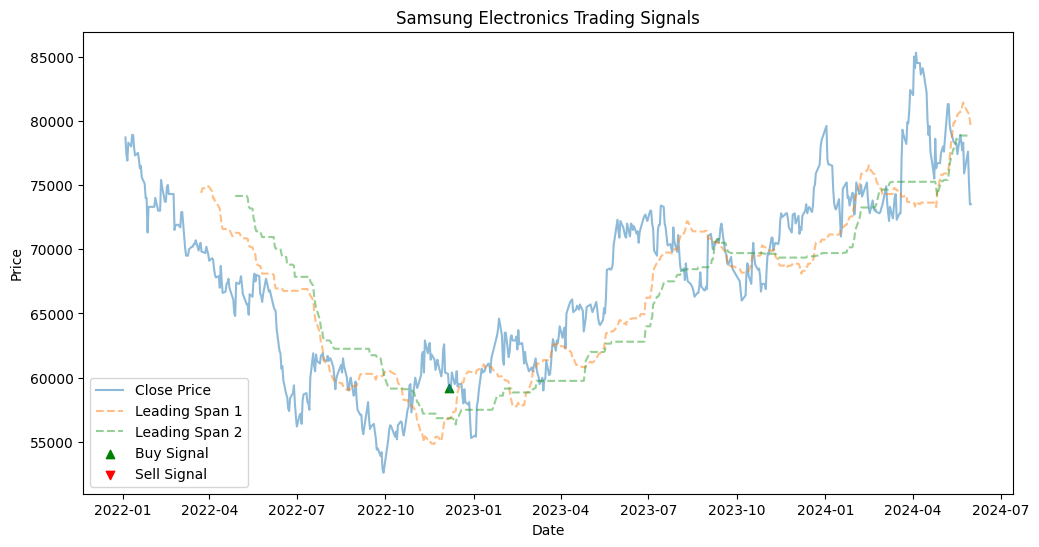

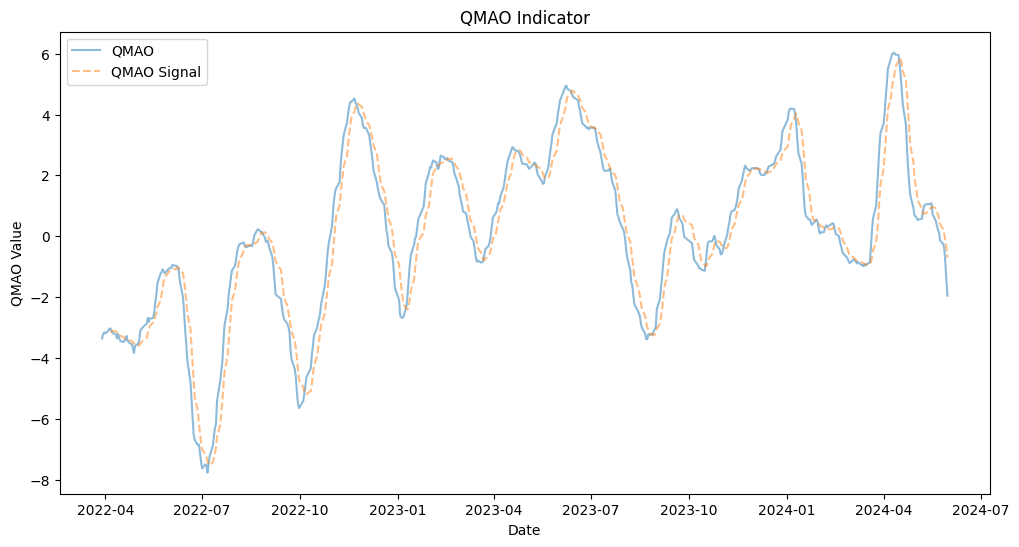

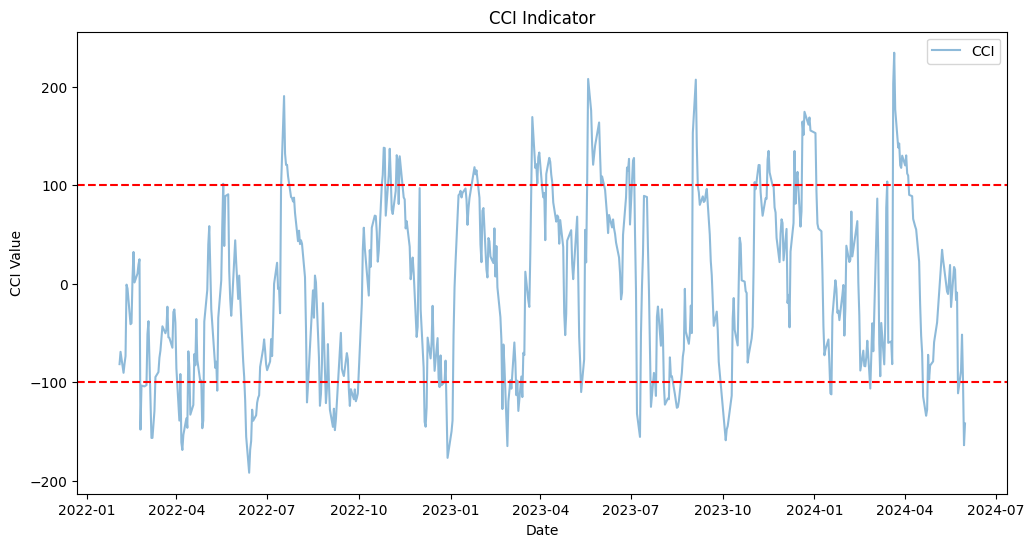

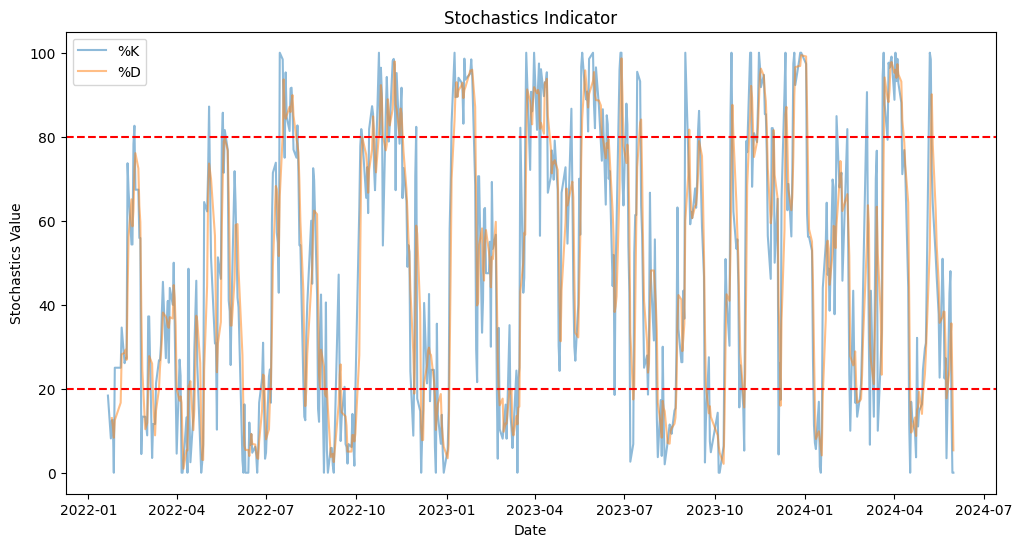

In [1]:
# Google Colab에서 yfinance 라이브러리를 설치
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# 삼성전자 데이터 다운로드
start_date = "2022-01-02"
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
stock_data = yf.download("005930.KS", start=start_date, end=end_date)

# 데이터 확인
stock_data.head()

# 일목균형표 계산
def ichimoku(df):
    nine_period_high = df['High'].rolling(window=9).max()
    nine_period_low = df['Low'].rolling(window=9).min()
    df['Conversion Line'] = (nine_period_high + nine_period_low) / 2

    period26_high = df['High'].rolling(window=26).max()
    period26_low = df['Low'].rolling(window=26).min()
    df['Base Line'] = (period26_high + period26_low) / 2

    df['Leading Span 1'] = ((df['Conversion Line'] + df['Base Line']) / 2).shift(26)

    period52_high = df['High'].rolling(window=52).max()
    period52_low = df['Low'].rolling(window=52).min()
    df['Leading Span 2'] = ((period52_high + period52_low) / 2).shift(26)

    df['Lagging Span'] = df['Close'].shift(-26)

    return df

stock_data = ichimoku(stock_data)

# CCI 계산
def CCI(df, n):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(n).mean()) / (0.015 * TP.rolling(n).std()), name='CCI')
    df = df.join(CCI)
    return df

stock_data = CCI(stock_data, 20)

# 볼린저 밴드 계산
def Bollinger_Bands(df, n):
    MA = df['Close'].rolling(window=n).mean()
    SD = df['Close'].rolling(window=n).std()
    df['Upper Band'] = MA + (2 * SD)
    df['Lower Band'] = MA - (2 * SD)
    return df

stock_data = Bollinger_Bands(stock_data, 20)

# QMAO 계산
def QMAO(df):
    df['7MA'] = df['Close'].rolling(window=7).mean()
    df['14MA'] = df['Close'].rolling(window=14).mean()
    df['28MA'] = df['Close'].rolling(window=28).mean()
    df['56MA'] = df['Close'].rolling(window=56).mean()

    A = ((df['7MA'] - df['14MA']) * (7+14)/315) + ((df['7MA'] - df['28MA']) * (7+28)/315) + ((df['7MA'] - df['56MA']) * (7+56)/315)
    B = ((df['14MA'] - df['28MA']) * (14+28)/315) + ((df['14MA'] - df['56MA']) * (14+56)/315)
    C = ((df['28MA'] - df['56MA']) * (28+56)/315)

    df['QMAO'] = (A + B + C) / df['Close'] * 100
    df['QMAO Signal'] = df['QMAO'].rolling(window=7).mean()

    return df

stock_data = QMAO(stock_data)

# Stochastics 계산
def Stochastics(df, nK, nD):
    df['L14'] = df['Low'].rolling(window=nK).min()
    df['H14'] = df['High'].rolling(window=nK).max()
    df['%K'] = (df['Close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=nD).mean()

    return df

stock_data = Stochastics(stock_data, 14, 3)

# 매매 신호 생성
def buy_sell_signals(df):
    buy_signals = []
    sell_signals = []
    position = False  # No position initially

    for i in range(len(df)):
        if df['Close'][i] > df['Leading Span 1'][i] and df['Close'][i] > df['Leading Span 2'][i]:
            if df['CCI'][i] < -100 and df['%K'][i] < 20:
                if not position:
                    buy_signals.append(df['Close'][i])
                    sell_signals.append(np.nan)
                    position = True
                else:
                    buy_signals.append(np.nan)
                    sell_signals.append(np.nan)
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        elif df['Close'][i] < df['Leading Span 1'][i] and df['Close'][i] < df['Leading Span 2'][i]:
            if df['CCI'][i] > 100 and df['%K'][i] > 80:
                if position:
                    buy_signals.append(np.nan)
                    sell_signals.append(df['Close'][i])
                    position = False
                else:
                    buy_signals.append(np.nan)
                    sell_signals.append(np.nan)
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    df['Buy Signal'] = buy_signals
    df['Sell Signal'] = sell_signals
    return df

stock_data = buy_sell_signals(stock_data)

# 차트 그리기
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price', alpha=0.5)
plt.plot(stock_data['Leading Span 1'], label='Leading Span 1', linestyle='--', alpha=0.5)
plt.plot(stock_data['Leading Span 2'], label='Leading Span 2', linestyle='--', alpha=0.5)
plt.scatter(stock_data.index, stock_data['Buy Signal'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(stock_data.index, stock_data['Sell Signal'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Samsung Electronics Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# QMAO와 CCI, Stochastics 차트 그리기
plt.figure(figsize=(12, 6))
plt.plot(stock_data['QMAO'], label='QMAO', alpha=0.5)
plt.plot(stock_data['QMAO Signal'], label='QMAO Signal', linestyle='--', alpha=0.5)
plt.title('QMAO Indicator')
plt.xlabel('Date')
plt.ylabel('QMAO Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(stock_data['CCI'], label='CCI', alpha=0.5)
plt.axhline(y=100, color='r', linestyle='--')
plt.axhline(y=-100, color='r', linestyle='--')
plt.title('CCI Indicator')
plt.xlabel('Date')
plt.ylabel('CCI Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(stock_data['%K'], label='%K', alpha=0.5)
plt.plot(stock_data['%D'], label='%D', alpha=0.5)
plt.axhline(y=80, color='r', linestyle='--')
plt.axhline(y=20, color='r', linestyle='--')
plt.title('Stochastics Indicator')
plt.xlabel('Date')
plt.ylabel('Stochastics Value')
plt.legend()
plt.show()